*Выполнила Набиуллина Розалия* \
# **Домашняя Работа 2 Линейная Регрессия**

# Импорт 

In [1]:
from google.colab import files 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Линейная регрессия для синтетических данных

# Генерация Данных

In [2]:
def true_fun(x, a=np.pi, b = 0, f=np.sin): # функция создания одномерных данных для последующего формирования ее в функцию
    x = np.atleast_1d(x)[:] # формируем список
    a = np.atleast_1d(a) # и тут тоже
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i + 1) for i,ai in enumerate(a)],axis=0) # здесь созданные данные линейны так как f = None

    return f(x + b)

def noises(shape , noise_power): # добавляем для большей похожести на практические данные
    return np.random.randn(*shape) * noise_power


def dataset(a, b, f = None,  N = 250, x_max = 1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed) # закрепляем определенную степень псевдослучайности
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [3]:
def vis_data(y, y_true,x, title): # визуализация сгенерированных данных
    fig  = plt.figure(figsize = (15,10))
    plt.scatter(x[:,0], y, edgecolor = 'b', label = "Зашумленные Данные",s = 196, alpha = 0.6)
    plt.scatter(x[:,0], y_true, label = "Реальные Данные", s = 81,c ='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x', fontsize = 35)
    plt.ylabel('y', fontsize = 35)
    plt.legend(fontsize = 25)
    plt.title(title, fontsize = 25)
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()


# **Линейная зависимость**

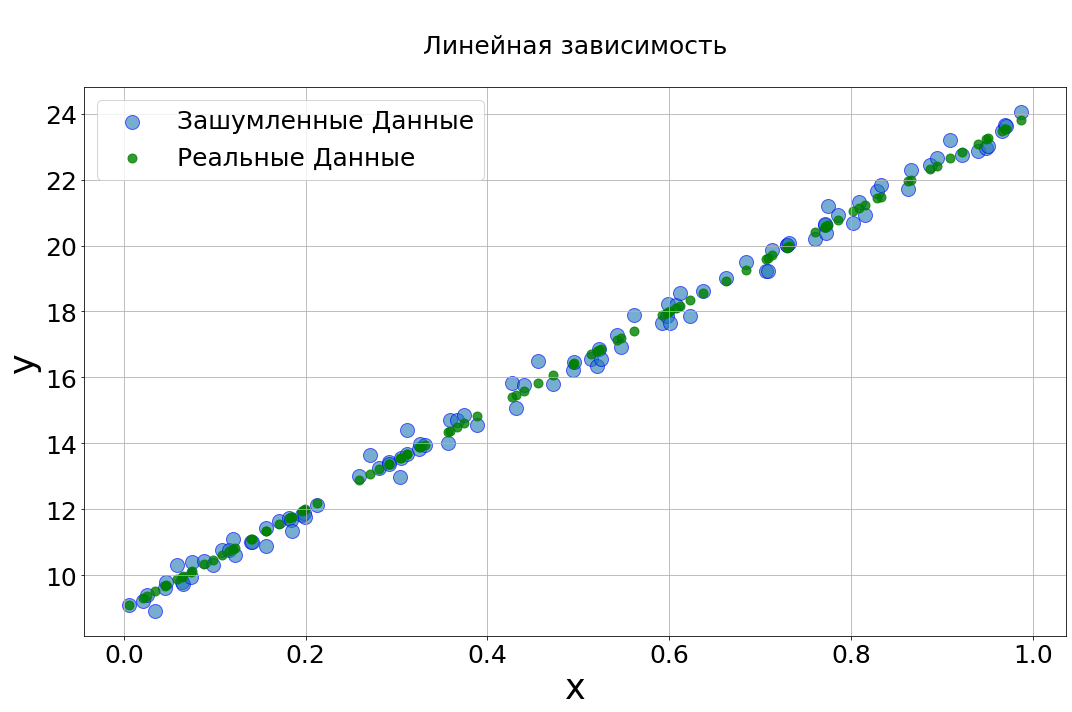

In [4]:
y, y_true, x = dataset(a = 15, b = 9, 
                       f = None,  N = 100,
                       x_max =1, 
                       noise_power = 0.3,
                       seed = 42)
vis_data(y, y_true,x, '\n Линейная зависимость \n')
# y = 15x + 9, шумы 30, зафиксированное рандомное состояние 42(а может 43 в следующий раз, мы же уже отгадали загадку вселенной)

*Внезапная часть теории*

**Три типа выборки:**
1. Обучающая выборка. С ее помощью мы обучаем модель. Ошибка на ней не должна стремится к нулю, так как модель может переучится(заучить эти данные, которые могут плохо предсказывать последующие данные)
2. Валидационная выборка. Она позволяет оценивать то, что модель не переучилась. Как правило один датасет делится на обучающую и валидационную выборки
3. Тестовая выборка. Нужна для итоговой проверки работы точности модели

In [5]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,): # train_size - размер тренировочной части  и test_size - размер тестовой части
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, ) # фиксируем тренировочную выборку   
# данные и полученные значения на тренировочной, валидационной и тестовой выборках
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )   # не фиксируем тренировочную выборку 
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )



(50, 1) (50,) (20, 1) (20,) (30, 1) (30,)
(70, 1) (70,) (30, 1) (30,)


In [6]:
def init_weights(W_shape, add_bias = True, random_state = 42): # функция инициализации весовых параметров (коэффициентов модели)
# Данная функция будет создавать случайный массив весовых параметров с нормальным распределением, имеющим 0 среднее разброс значений  1/ √weight.size
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))    
    if add_bias:  # имеем возможность создавать набор весов с учетом смещения
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

In [7]:
def predict( X, W, add_bias = True): # функции предсказания
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X)) # для учета смещения мы будем добавлять единичный столбец к входным данным
    else:
        X_full = X
    return  np.dot(X_full,W)

def loss_func(yhat, y): # расчета значений функции потерь
    return np.square(yhat - y)  # функция потерь регрессии loss_func как квадрат разности между целевыми значениями и их предсказаниями

In [8]:
weights = init_weights(x.shape[1])
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0]) 

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}') # потери очень большие поэтому стоит внимательнее подбирать веса

[0.         0.49671415]
predict [0.4015424],
ground truth [9.10894588],
loss: [75.81887525]


Посмотрим на график того как меняется функция потерь в зависимости от отклонения (мультипликативного) оценки результата от его истинного значения.

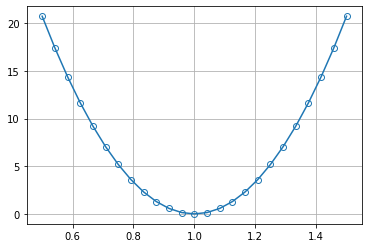

In [9]:
decline = np.linspace(start = 0.5, stop = 1.5, num = 25)
yhat = decline * y[0]
loss = loss_func(yhat, y[0])
plt.plot(decline,loss,'-o', mfc = 'none'); plt.grid(); 

In [10]:
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  # возвращаем производную функции потерь по оптимизируемым параметрам
    # 

In [11]:
yhat = predict(x_train[0], weights) # расчет градиента ошибки

grad = grad_loss(yhat, y[0], x[0])
print(grad)

[-17.41480695  -0.0961666 ]


In [12]:
def update_weights(grad, W, learning_rate): # опимизация методом градиентного спуска, последовательный (итерационный) пересчет значений весовых параметров обратно значеням градиента ошибки (то есть в направлении, обратном направлению роста ошибки)
    return W - learning_rate * grad

In [13]:
learning_rate = 0.1
weights = update_weights(grad, weights, learning_rate) # обновление весовых параметров
print(weights)

[1.74148069 0.50633081]


In [14]:
yhat = predict(x_train[0], weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[1.74148069 0.50633081]
predict [2.15079718],
ground truth [9.10894588],
loss: [48.41583327]


In [15]:
def fit(X, y, learning_rate, weights = None,  epochs=30): # обучение или задача оптимизации методом градиентного спуска
# epoch(эпоха) - одна итерация в методе градиентного спуска
    if weights is None: weights = init_weights(X.shape[1]) # X - набор входных значений (т.н. батч) в формате: число записей * значения в записи ;
    cost = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X) 
        weights = update_weights(grad, weights, learning_rate)  # weights - начальные значения весовых параметров # lr  - скорость обучения ( η )
        cost[i] = loss_func(yhat,  y).mean() # cost  - график функции потерь
                
    return weights, cost # weights - набор обученных весовых параметров

Протестируем обучение

In [16]:
weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=10)


In [17]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize = 35)
    plt.ylabel("\nФункция Потерь\n",fontsize = 35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);  

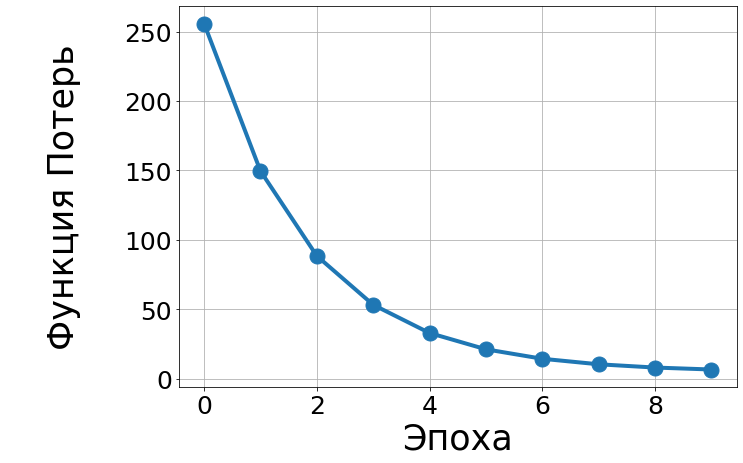

In [18]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

Функция потерь потихоньку снижается -- ОТЛИЧНО!

In [19]:
def r2_score(yhat, y):   # расчитываем среднеквадратичную ошибку 
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

In [20]:
predicts = predict(x_test, weights,)

r2_score(predicts, y_test), r2_score(predict(x_train, weights, ), y_train)

(0.6290136180646686, 0.7088631358969386)

Посмотрим на то, какая интерпретация может быть у предсказанных и заданных данных. 

In [21]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

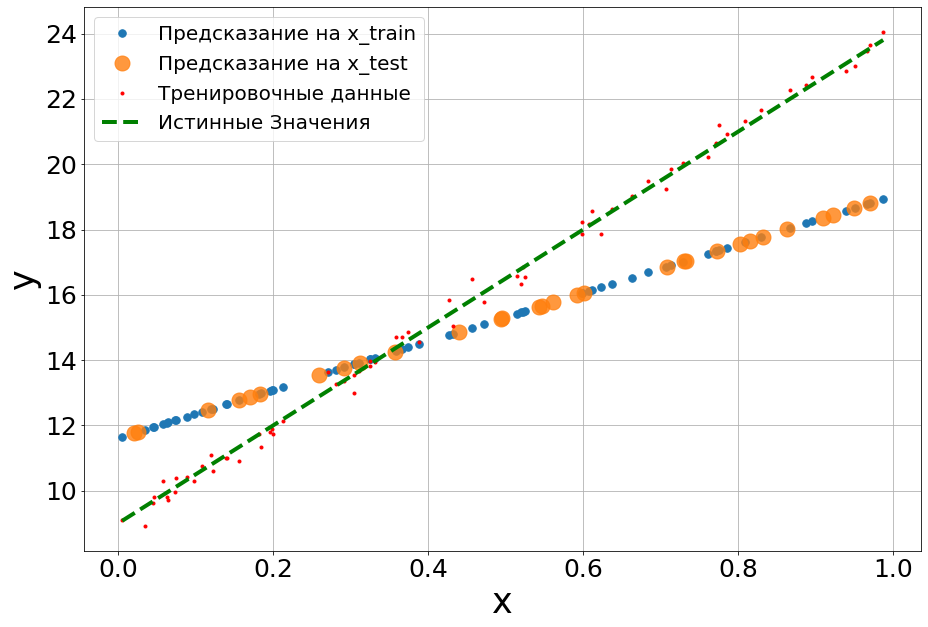

In [22]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

не сходятся данные и предсказания на тренировочной выборке -- нужно менять ВЕСА

In [23]:
weights

array([11.61369488,  7.41219308])

In [24]:
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels );

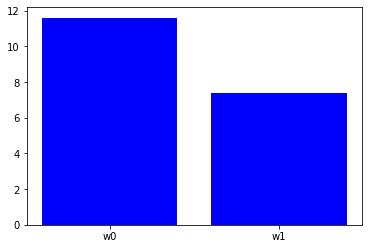

In [25]:
vis_weigths(weights)

In [26]:
def load_batch(X,y, batch_size = 100): # генерируем мини пакет данных(батч), потому что на каждой эпохе можно рассматривать меньшее количество данных
# функция для генерации минибатчей заданного размера
    idxs = np.arange(y.size)
    np.random.shuffle(idxs)

    for i_batch in range(0,y.size,batch_size):
        idx_batch = idxs[i_batch:i_batch+batch_size]
        x_batch   = np.take(X, idx_batch,axis=0)
        y_batch   = np.take(y, idx_batch)
        yield  x_batch, y_batch

In [27]:
BATCH = 10

def fit_SGD(X, y, lerning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42): 
    # функция оптимизации методом стохастического градиентного спуска чтобы минимизировать перебор оптимальных весов
    if random_state: np.random.seed(random_state)

    if weights is None: weights = init_weights(X.shape[1])
    if batch_size is None or batch_size>y.size : batch_size = y.size
    n_batches = y.size//batch_size
    
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        loss = 0
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): 

            yhat    = predict(x_batch, weights)
            grad    = grad_loss(yhat,  y_batch, x_batch) 
            weights = update_weights(grad, weights, lerning_rate) #backward 
            loss   += loss_func(yhat,  y_batch).mean()

            if cnt>= n_batches:
                break
        cost[i] = loss/n_batches

    return weights, cost

In [28]:
weights = init_weights(x_train.shape[1], random_state=42)

weights, cost = fit_SGD(x_train, y_train, lerning_rate=0.1, batch_size = 10,  epochs=10) # генерируем веса с помощью стохастического градиентного спуска

predicts = predict(x_test, weights, )
r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.9583546383240105, 0.9497010098543737)

In [29]:
weights # веса уже скорректировались

array([10.56544913, 11.98276401])

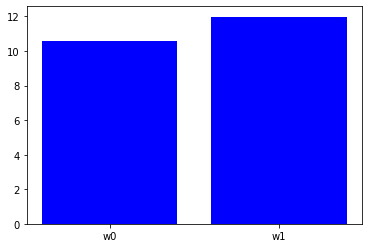

In [30]:
vis_weigths(weights)

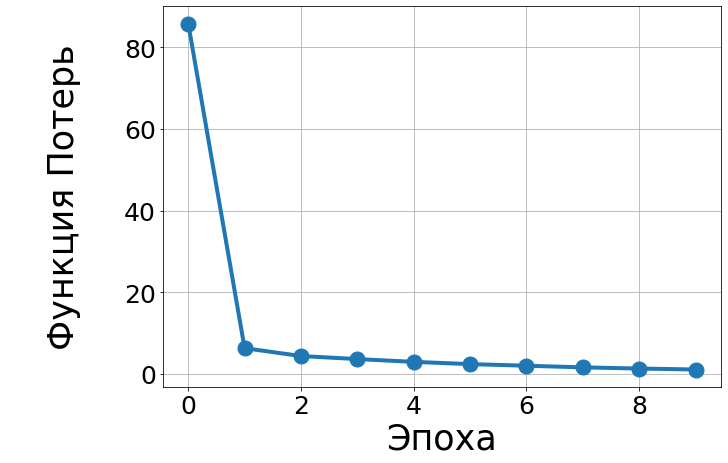

In [31]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

потери больше снижаются значит, или модель переобучилась, или мы делаем всё как нужно

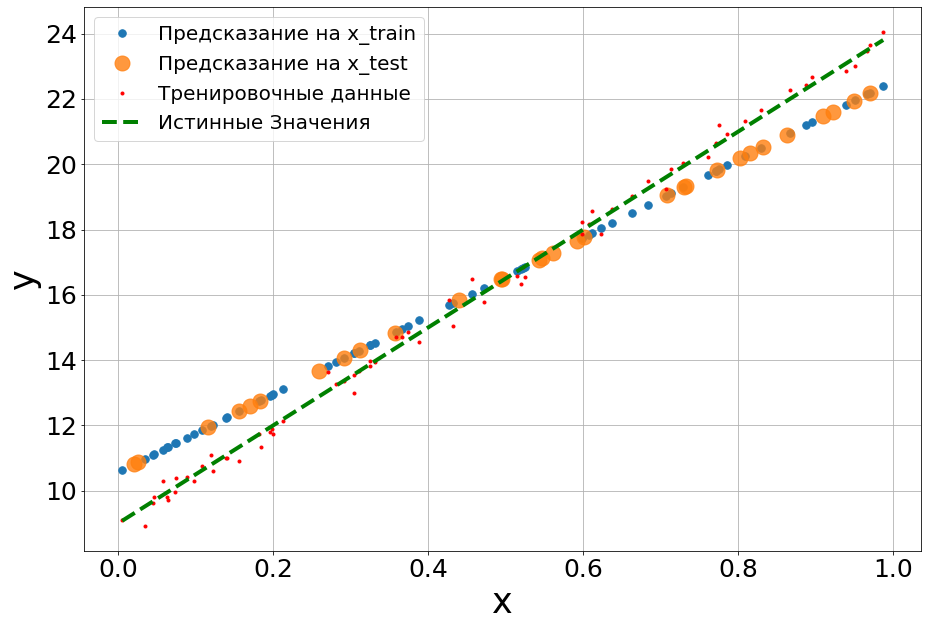

In [32]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

Здесь понимаю, что всё же первое -- модель хорошо обучилась

Теперь давайте объеденим все наши часть в один класс линейной регресии.
<!-- <br> При объединении мы сделаем две дополнительные модификации нашей модели.
<ul>
    <li> во-первых, введем в модель дополнительный член - смещение ($b$), тогда можно записать модель так:
        $$\begin{align*}
        &\hat{y}_i = \sum_{j=0}^{M-1}x_{ij}w_j+b \\
        \text{   или так: }&\hat{y}_i = \sum_{j=0}^{M}x_{ij}w_j, x_{i0} \equiv 1.
        \end{align*}$$
        обе запси формально равнозначны. <ul>
        при этом отметим, что градиент функции потерь по остаточному члену можно записать следующим образом:
        $$b^t = b^{t-1}-\eta\nabla_{b}L(\hat{y}_i,y_i)=b^{t-1} - 2\eta(\hat{y}_i-y)$$
        </ul>
        Мы будем использовать второй вариант, то есть объеденим веса и смещния, а к данным добавим столбец едениц.
<li> Во воторых запишем все обозначенные функции в один класс.
<li> В третьих проведем векторизацию в тех местах, где у нас стояли лишнии циклы.
    <br> В том числе отметим, что выражение для расчет суммарного градиента может быть записано векторно в следующей форме
    $$2\sum_{i=0}^{M-1}(\hat{y}_i-y_i)\odot X_i^T = 2 X_i^T(\hat{y}-y), $$ 
    где $\hat{y}, y$ - массивы значений оценок и целевых результатов.
     -->

In [33]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X): #  функция расчета (предсказания) значений
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

# Полиномальная Зависимость

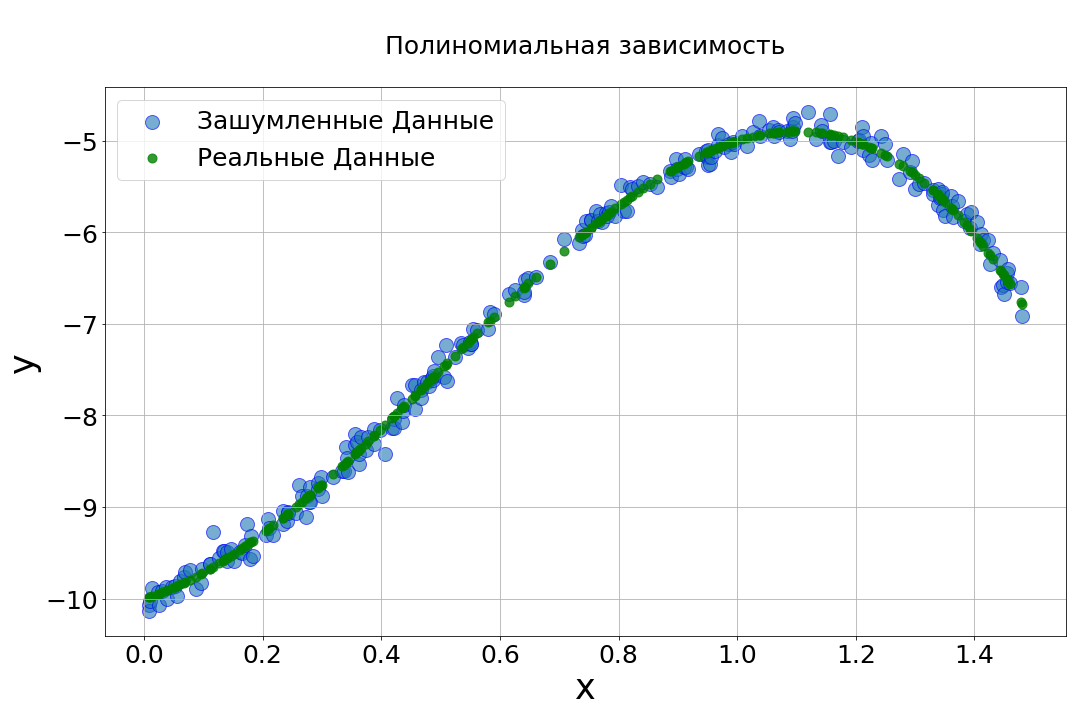

In [121]:
y, y_true, x = dataset(a = [2, 9, -6], b = -10, # y= 2x^3 + 9x^2 - 6x - 10
                       f = None,  N = 250,
                       x_max = 1.5, 
                       noise_power = 0.1,
                       seed = 42)
vis_data(y, y_true,x, '\n Полиномиальная зависимость \n')

In [122]:
x_train, y_train,  x_test, y_test = train_test_split(x, y, test_size=0.3, )    

In [123]:
regr_poly_lin = LinearRegression(learning_rate = 0.1, # инициализация линейной модели на данных полиноминальной регрессии
                        epochs = 10, batch_size = 10,
                        n_batches = None)
regr_poly_lin.fit(x_train, y_train) # обучаю полиномиальную регрессию

In [124]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label = 'Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label = 'Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label = "Тренировочные данные", linewidth = 2, c = 'r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth = 4, c = 'g')
    plt.legend(fontsize = 20); plt.grid()
    plt.xlabel('x', fontsize = 35)
    plt.ylabel('y', fontsize = 35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

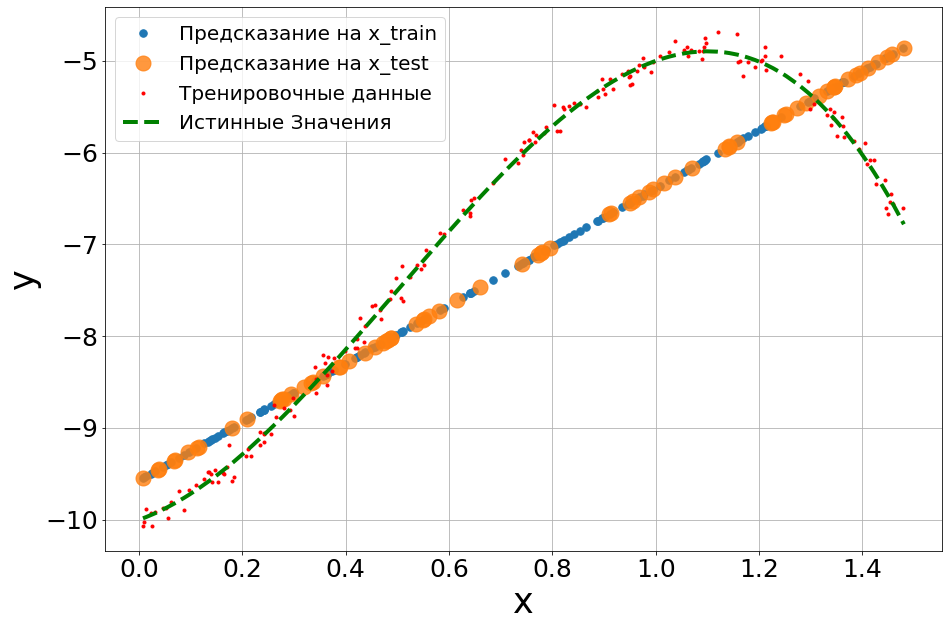

In [125]:
fig  = plt.figure(figsize = (15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin)

Вижу, что линейная модель не очень справляется с данными поэтому будем искать полином, который будет иметь число столбцов, равное степени искомого полинома

In [126]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T # транспонирую матрицу

In [127]:
x_ = to_polynom(x, order = 5) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y, test_size=0.3, )

In [139]:
regr_poly = LinearRegression(learning_rate = 0.07, # полиномиальная модель на полимиальных данных
                        epochs=100, batch_size = 10,
                        n_batches=None)

In [140]:
regr_poly.fit(x_train, y_train)

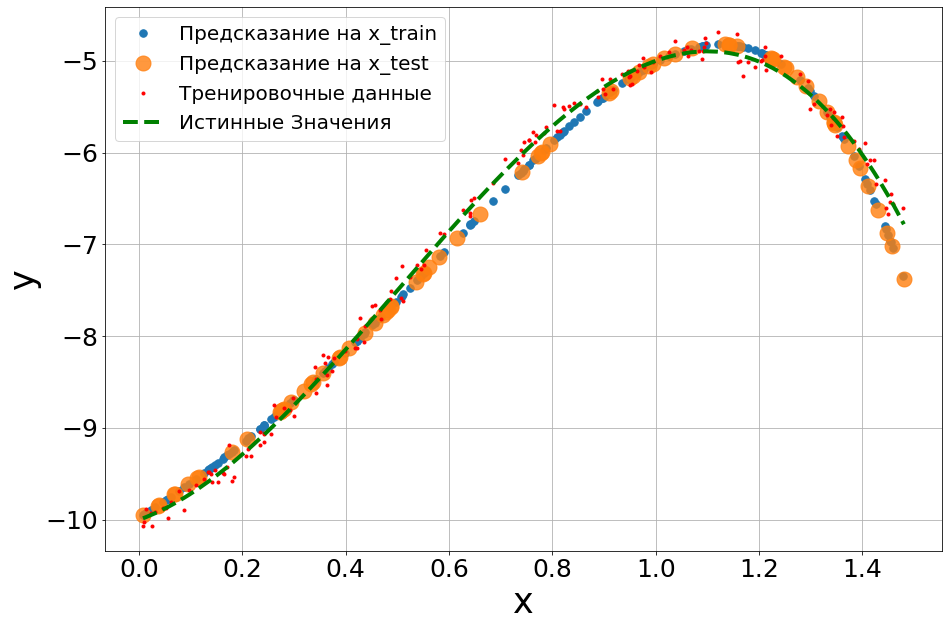

In [141]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)

Успешно обучила модель 

# Гармонические данные

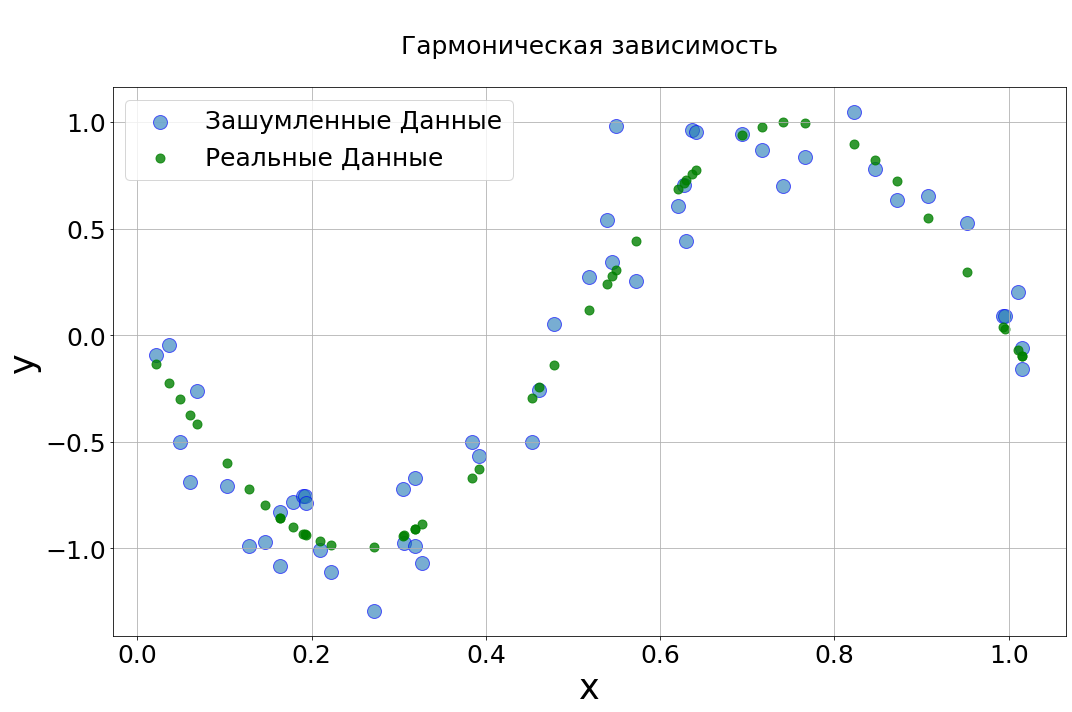

In [145]:
y, y_true, x = dataset(a = 2*np.pi, # возьмем всего одну длину волны
                       b = np.pi, f = np.sin,  
                       N = 51, x_max = np.pi/3, 
                       noise_power = 0.2, seed = 42)
vis_data(y, y_true,x, '\nГармоническая зависимость\n')

In [146]:
x_train, y_train,  x_test, y_test = train_test_split(x, y, test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(35, 1) (35,) (16, 1) (16,)


### Линейная регрессия для гармонических данных


Train Score = 0.46



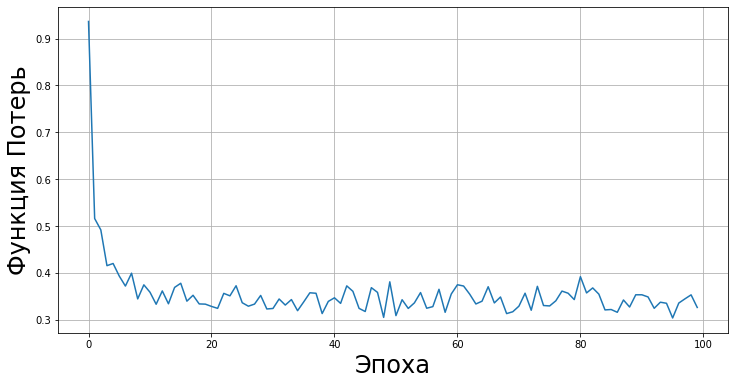

In [153]:
regr_harm = LinearRegression(learning_rate = 0.18,
                        epochs = 100, batch_size = 10,
                        n_batches = None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}\n')
regr_harm.plot_cost()

Вижу, что потери всё еще большие(чуть меньше 40%)

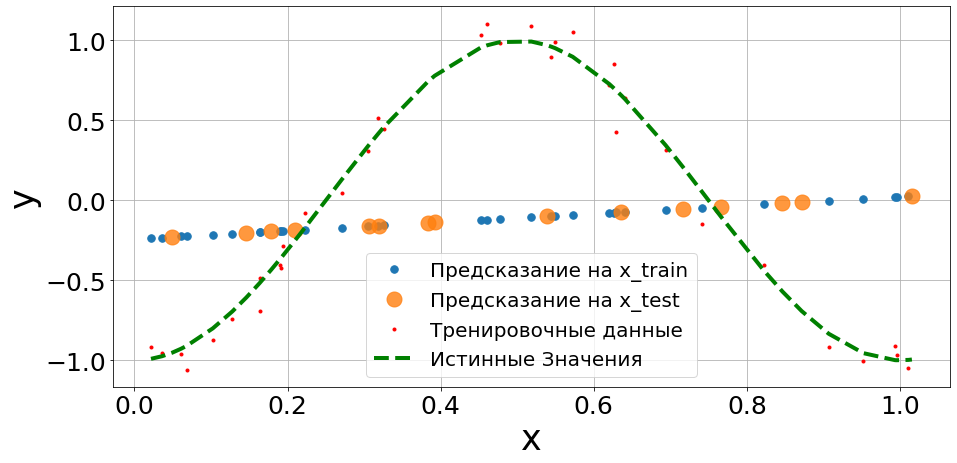

In [47]:
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_harm)

Линейная модель не подходит для наших данных

In [48]:
w, b = regr_harm.get_w_and_b()
print(w,b)

[0.26398754] -0.24167518488441947


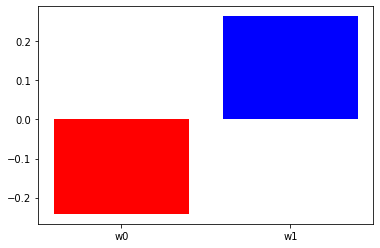

In [49]:
vis_weigths(np.hstack([b,w]))

### Полиномиальная регрессия для гармонических данных


In [158]:
order  = 11 # создаю набор данных

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)

pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9,10
31,0.102282,0.010462,0.001070,0.000109,1.119428e-05,1.144973e-06,1.171101e-07,1.197826e-08,1.225160e-09,1.253118e-10,1.281714e-11
32,0.544614,0.296604,0.161535,0.087974,4.791195e-02,2.609352e-02,1.421089e-02,7.739451e-03,4.215013e-03,2.295555e-03,1.250191e-03
33,0.693792,0.481347,0.333955,0.231695,1.607480e-01,1.115256e-01,7.737555e-02,5.368252e-02,3.724449e-02,2.583992e-02,1.792752e-02
34,0.036012,0.001297,0.000047,0.000002,6.056345e-08,2.180985e-09,7.854071e-11,2.828375e-12,1.018542e-13,3.667931e-15,1.320880e-16


Test Score = 0.83, Train Score = 0.72


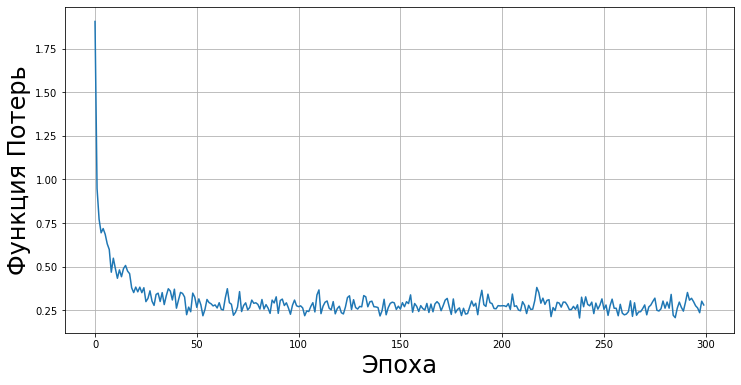

In [167]:
regr_harm_poly = LinearRegression(learning_rate = 0.2, # инициализация полиномиальной модели для гармонических данный
                        epochs = 300, batch_size = 25,
                        n_batches = None)

regr_harm_poly.fit(x_train_, y_train) # обучение
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

Модель (на этот раз полиномиальная) не очень подходит для наших данных

In [169]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 0.63851109  1.52815049  1.09442056  0.6319946  -0.37001751 -0.61460967
 -0.15696515 -0.39420772 -0.70297812 -0.30242013 -0.49470933] -0.8379869128002877


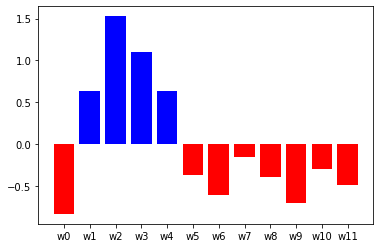

In [170]:
vis_weigths(np.hstack([b,w]))

Вижу, что модель правильно предполагает какие примерно степени признакого параметра нужно больше учитывать

In [54]:
np.sum(np.abs(w))

5.647463879933974

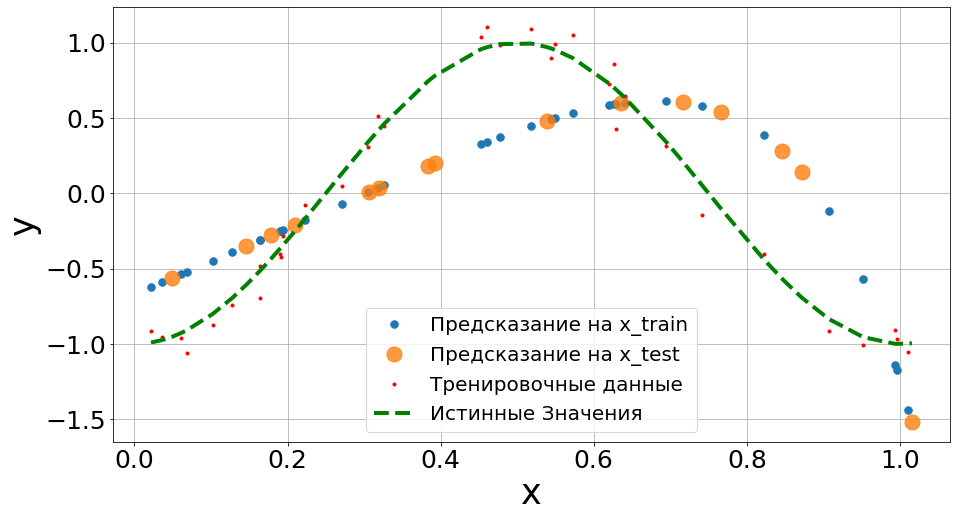

In [55]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly)

In [173]:
scaler = StandardScaler() # импортируем библиотеку для нормализации данных из таблицы для подбора полинома
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

In [174]:
pd.DataFrame(x_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8,9,10
12,1.159851,1.134187,1.001418,0.838403,0.676608,0.527244,0.393746,0.276559,0.174902,0.087484,0.012824
13,-0.847345,-0.837394,-0.736392,-0.648576,-0.586794,-0.544625,-0.515173,-0.493750,-0.477457,-0.464529,-0.453881
14,0.189883,-0.115871,-0.308824,-0.409749,-0.456245,-0.473836,-0.476915,-0.473109,-0.466334,-0.458541,-0.450660
15,0.750434,0.538727,0.306897,0.111890,-0.038622,-0.150670,-0.232343,-0.290850,-0.332014,-0.360360,-0.379337


Test Score = 0.77, Train Score = 0.68


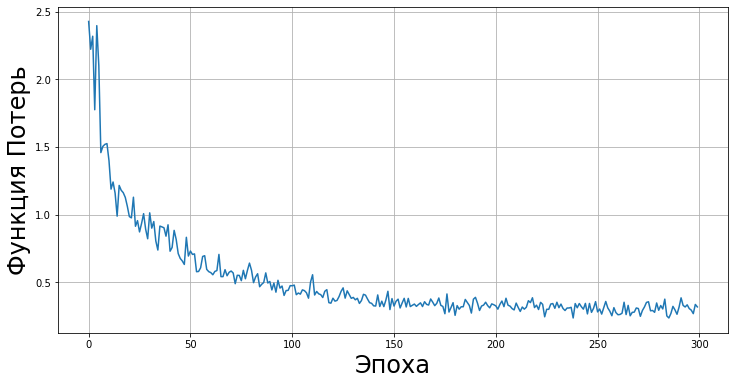

In [195]:
regr_harm_poly_scale = LinearRegression(learning_rate = 0.003, # модель-полином с нормализованными данными
                        epochs = 300, batch_size = 25,
                        n_batches = None)

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Всё равно достаточно большие потери

In [196]:
w, b = regr_harm_poly_scale.get_w_and_b() # взглянем на веса
print(w,b)

[ 0.39221242  0.12514126  0.24065611  0.40893593 -0.18590585 -0.22825365
  0.29129923  0.02921498 -0.35464881 -0.05625913 -0.36358636] -0.07564329502048313


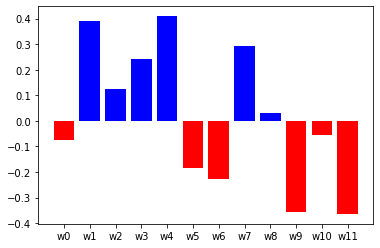

In [197]:
vis_weigths(np.hstack([b,w])) # такое ощущение что модель начинает переобучиваться

In [198]:
np.sum(np.abs(w))

2.676113717064463

Посмотрим на результат

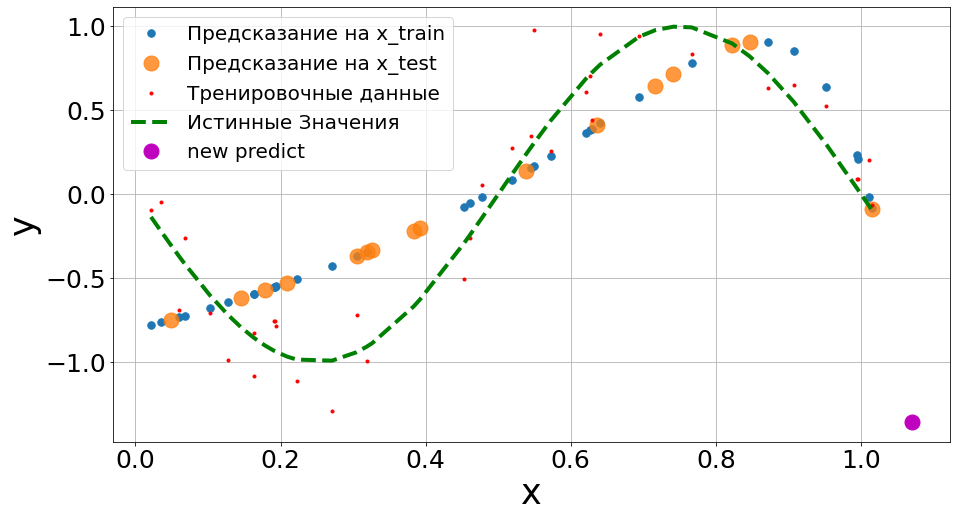

In [199]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);

Новое предсказание не очень точно...
Воспользуемся еще одним методом

### Метод Наименьших Квадратов 

Для более детального сравнения давайте также посмотрим на аналитическое решение проблемы.

In [221]:
order = 11
x_train_ls = to_polynom(x_train, order=order, add_bias=True)
x_test_ls  = to_polynom(x_test,  order=order, add_bias=True)
weights  = np.linalg.lstsq(x_train_ls, y_train, rcond=None)[0] #including bias

In [222]:
weights

array([-5.70431732e-01,  4.78455208e+01, -1.49818194e+03,  1.81837554e+04,
       -1.18797936e+05,  4.68597093e+05, -1.17965126e+06,  1.94222092e+06,
       -2.08597898e+06,  1.40975910e+06, -5.44656007e+05,  9.17743298e+04])

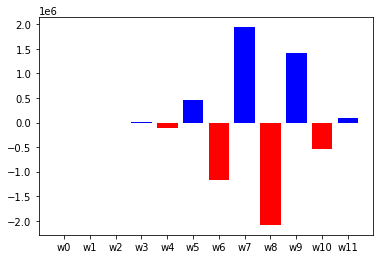

In [223]:
vis_weigths(weights)

In [224]:
np.sum(np.abs(weights))

7861165.973720476

In [225]:
def polyval(x,weights):
    return np.sum([np.power(x,i)*wi for i, wi in enumerate(weights) ],axis = 0) # including bias!

In [226]:
print(f"Test score: {r2_score(y_test, polyval(x_test,weights).squeeze()):.2f}, Train score: {r2_score(y_train, polyval(x_train,weights).squeeze()):.2f}")


Test score: 0.94, Train score: 0.92


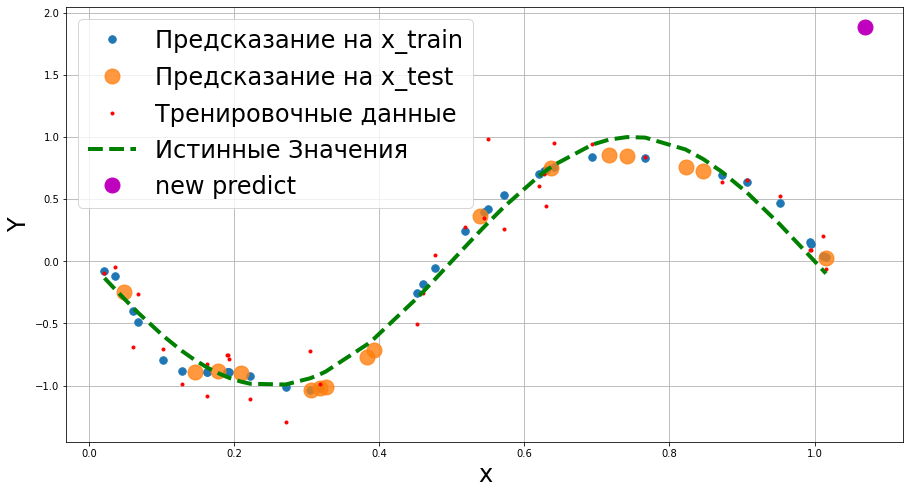

In [227]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], polyval(x_train, weights),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], polyval(x_test, weights),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         polyval([1.07], weights), 
         'mo',  label = 'new predict',
        markersize = 15 )

plt.grid()
plt.legend(fontsize = 24)
plt.xlabel('x', fontsize = 24)
plt.ylabel('Y', fontsize = 24)
plt.show()

Аналитическое решение методом наименьших квадратов дало результаты лучше чем численное

Однако, градиентный спуск позволяет поднять точность на тестовых данных.

## Регуляризация линейной регрессии

### Регуляризация Тихонова

In [228]:
class RidgeRegression(LinearRegression): # ridge(or l2) regularization
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  


Test Score = 0.84, Train Score = 0.74


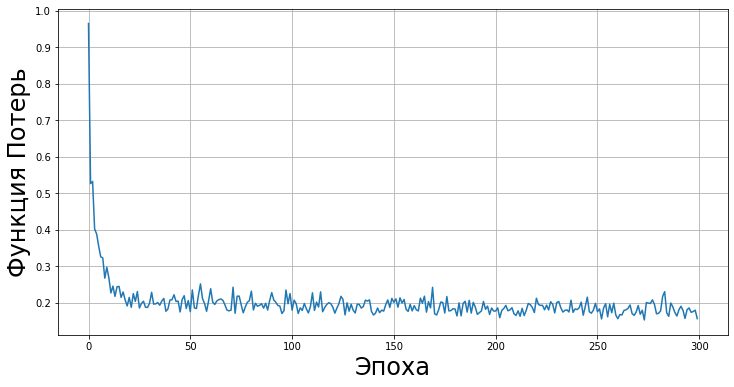

In [231]:
regr_l2 = RidgeRegression(learning_rate=0.2,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l2.score(x_test_, y_test):.2f}, Train Score = {regr_l2.score(x_train_, y_train):.2f}')
regr_l2.plot_cost()

In [232]:
w, b = regr_l2.get_w_and_b()
print(w,b)

[ 0.18664986  2.21981786  1.45453587  0.57681733 -0.65142093 -0.95093557
 -0.43514182 -0.54854821 -0.6993276  -0.12605194 -0.14232478] -0.7809324540638647


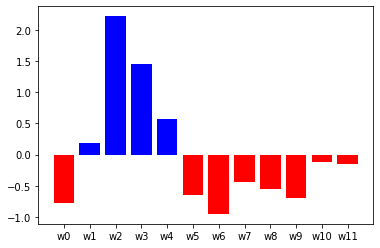

In [233]:
vis_weigths(np.hstack([b,w]))

In [234]:
np.sum(np.abs(w))

7.991571769464978

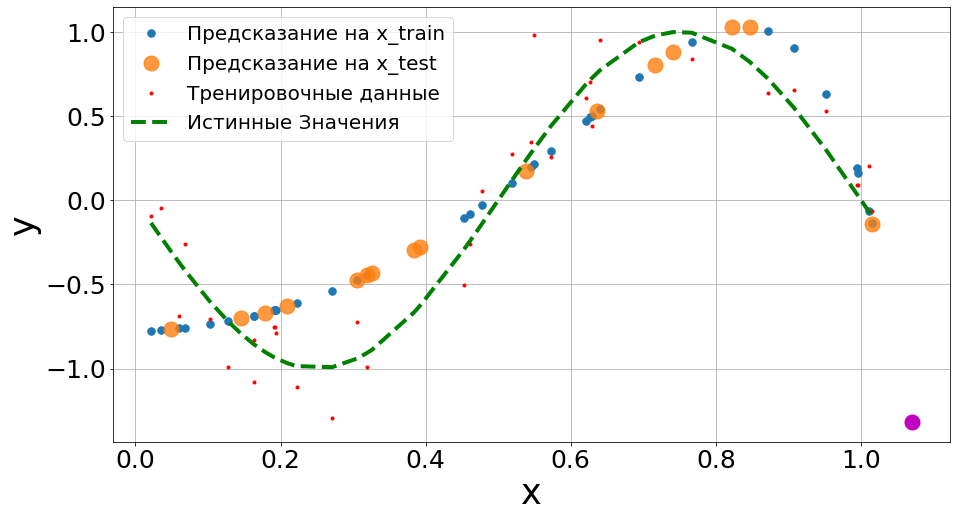

In [235]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l2)

plt.plot([1.07], 
         regr_l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

### Регуляризация L1


In [78]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

Test Score = 0.83, Train Score = 0.73


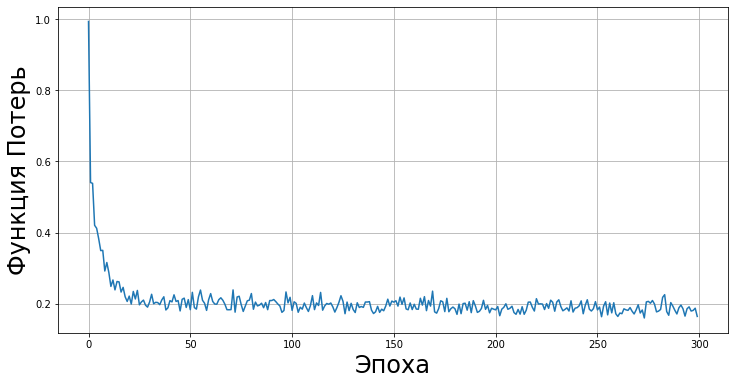

In [237]:
regr_l1 = LassoRegression(learning_rate=0.17,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1.fit(x_train_, y_train)

print(f'Test Score = {regr_l1.score(x_test_, y_test):.2f}, Train Score = {regr_l1.score(x_train_, y_train):.2f}')
regr_l1.plot_cost()

In [238]:
w, b = regr_l1.get_w_and_b()
print(w,b)

[ 0.36965253  2.01681895  1.25043722  0.41253297 -0.40603855 -0.74019498
 -0.3546202  -0.47562666 -0.68874412 -0.19425345 -0.2768877 ] -0.7960108387020604


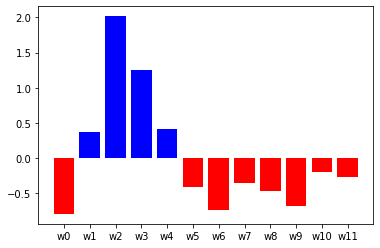

In [239]:
vis_weigths(np.hstack([b,w]))

In [240]:
np.sum(np.abs(w))

7.185807327750499

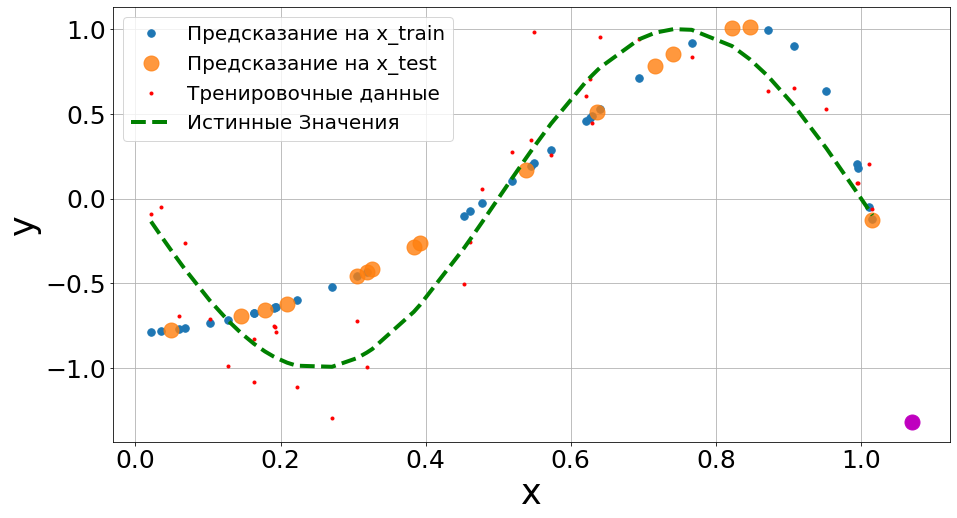

In [241]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1)

plt.plot([1.07], 
         regr_l1.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

### Эластичная регуляризация

In [242]:
class ElasticRegression(LinearRegression): # комбинация Л1 и Л1 регуляризаций
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

Test Score = 0.83, Train Score = 0.73


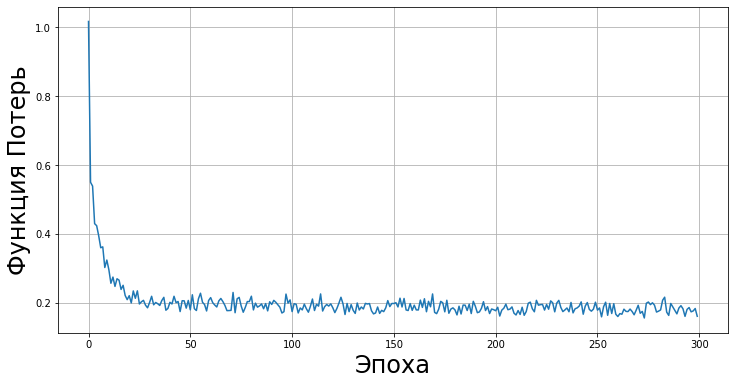

In [244]:
regr_l1l2 = ElasticRegression(learning_rate=0.15,
                         epochs=300,batch_size=10,
                         l1_penalty = 0.0001,l2_penalty = 0.001 )
regr_l1l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l1l2.score(x_test_, y_test):.2f}, Train Score = {regr_l1l2.score(x_train_, y_train):.2f}')
regr_l1l2.plot_cost()

In [245]:
w, b = regr_l1l2.get_w_and_b()
print(w,b)

[ 0.42547175  1.88941112  1.27743382  0.5957326  -0.49226746 -0.77080299
 -0.29895435 -0.46871207 -0.70002619 -0.2156733  -0.32092281] -0.8060291259734114


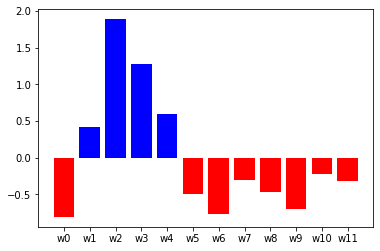

In [246]:
vis_weigths(np.hstack([b,w]))

In [247]:
np.sum(np.abs(w))

7.45540846944056

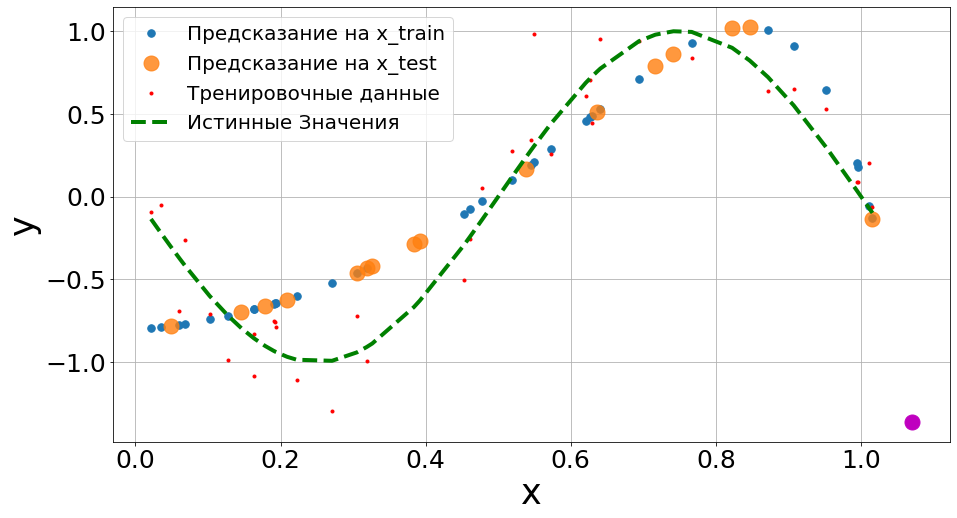

In [248]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1l2)

plt.plot([1.07], 
         regr_l1l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

**ВЫВОДЫ**

В ходе исполнения этой лабораторной я узнала как практически исполнять линейную регрессию на разных видах данных и как использовать три вида регуляризаций